In [1]:
import numpy as np
import argparse
import os
import time
import glob
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from utils.dataGenerator import DataGenerator, DataGenerator_metaData
from utils import utils

In [2]:
print("tf version: ", tf.__version__)
print("keras version: ", tf.keras.__version__)
print("")

# GPU availability
tf.test.gpu_device_name()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

tf version:  2.4.0
keras version:  2.4.0

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2879716397943513775
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9874664320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10208024330838974027
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
# data folders
patches_folder = r"D:\annotated_slides\separate_patches_and_labels_hooknet_exp_1"
svsfolder = r"D:\annotated_slides\Slides"

slide_patches = glob.glob(os.path.join(patches_folder,'*.h5'))
print("number of slide patches: ", len(slide_patches))

number of slide patches:  122997


In [4]:
# # Load csv file
# df = pd.read_csv(os.path.join(svsfolder, "csv_file.csv"))

# slide_ids = list(df['slide_id'].values)
# train_ids, val_test_ids = train_test_split(slide_ids, test_size=0.30, random_state=42)
# validation_ids, test_ids = train_test_split(val_test_ids, test_size=0.35, random_state=42)

# print("train: {:d}, validation: {:d}, test: {:d}".format(len(train_ids), len(validation_ids), len(test_ids)))  

# train_patches = []
# validation_patches = []
# test_patches = []
# for patch_path in slide_patches:
#     patch_name = patch_path.split("\\")[-1]
    
#     for tran_id in train_ids:
#         if tran_id in patch_name:
#             train_patches.append(patch_name)
#             break
    
#     for val_id in validation_ids:
#         if val_id in patch_name:
#             validation_patches.append(patch_name)
#             break
            
#     for test_id in test_ids:
#         if test_id in patch_name:
#             test_patches.append(patch_name)
#             break
            
# # # print([x for x in train_patches if x in validation_pathes])
# print("train patches: {:d}, validation patches: {:d}, test patches: {:d}".format(
#     len(train_patches), len(validation_patches), len(test_patches)))  

# partition = {'train': train_patches,
#              'validation': validation_patches,
#              'test': test_patches}

classmeta_test = pd.read_csv(os.path.join(patches_folder, "classmeta_test.csv"))
classmeta_validation = pd.read_csv(os.path.join(patches_folder, "classmeta_validation.csv"))
classmeta_train = pd.read_csv(os.path.join(patches_folder, "classmeta_train.csv"))

print("test patches: {:d}".format(len(classmeta_test)))

test patches: 2781


In [5]:
# load model
main_folder = r"D:\annotated_slides"
modeldir = os.path.join(main_folder, 'models')
modelfile = 'model_hooknet_exp_1.h5'
hooknet = load_model(os.path.join(modeldir, modelfile))


In [6]:
# classnames = ['Mastopatic', 'CIS', 'Necrosis', 'NormalEpithelial', 'IDC', 'Stroma', 'Lymfocyten',
#               'Adipose', 'RedBlood', 'ILC']
classnames = ['CIS', 'IDC', 'ILC', 'Stroma', 'Adipose', 'Other']
le = preprocessing.LabelEncoder()

if classnames is not None:
    le.fit(classnames)
    print('classes: ', list(le.classes_))
    new_class_names = ['unknown'] + list(le.classes_)
#     new_class_names = list(le.classes_)


print("new class names: ", new_class_names)

classes:  ['Adipose', 'CIS', 'IDC', 'ILC', 'Other', 'Stroma']
new class names:  ['unknown', 'Adipose', 'CIS', 'IDC', 'ILC', 'Other', 'Stroma']


In [7]:
# custom color map

N = 7  # Number of labels

# colors for segmented classes
colorB = [255, 128, 232, 70, 156, 153, 153,  30,   0,  35, 152]
colorG = [255,  64,  35, 70, 102, 153, 153, 170, 220, 142, 251]
colorR = [255, 128, 244, 70, 102, 190, 153, 250, 220, 107, 152]
colorA = [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
CLASS_COLOR = list()
for i in range(0, len(colorB)):
    CLASS_COLOR.append([colorR[i], colorG[i], colorB[i], colorA[i]])
COLORS = np.array(CLASS_COLOR, dtype="float32")
COLORS = COLORS/255

cmap = colors.ListedColormap(COLORS)

# define the bins and normalize
bounds = np.linspace(0, N, N + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)


In [8]:
params = {'dim': (256, 256),
          'batch_size': 14, 
          'n_classes': 7,
          'n_channels': 3,
          'shuffle': True,
          'mode': 'test',
          'data_folder': r"D:\annotated_slides\separate_patches_and_labels_hooknet_exp_1"}

# Generator
test_generator =  DataGenerator_metaData(classmeta_test, **params)

In [9]:
# example data generator
max_iter = 1  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
i = 0
for (patch_c, patch_t), (seg_c, seg_t) in test_generator:
    i += 1
    if i == max_iter:
        break

seg_c:  (array([3.]), array([65536], dtype=int64))
seg_t:  (array([3.]), array([65536], dtype=int64))


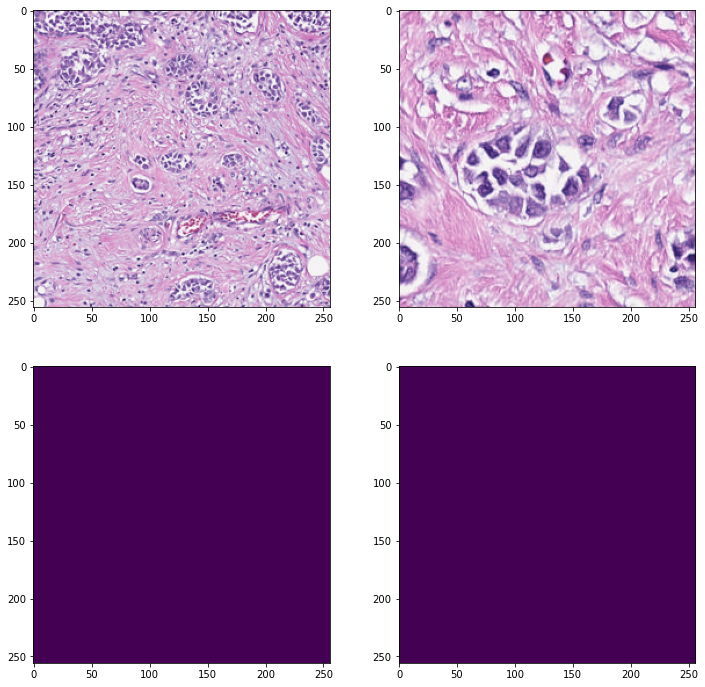

In [10]:
i = 0
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0][0].imshow(patch_c[i])
ax[0][1].imshow(patch_t[i])
ax[1][0].imshow(seg_c[i])
ax[1][1].imshow(seg_t[i])

print("seg_c: ", np.unique(seg_c[i], return_counts=True))
print("seg_t: ", np.unique(seg_t[i], return_counts=True))

   class_id class_name  y_class_count  yp_class_count
0       3.0        IDC        65536.0           65518
1       4.0        ILC            NaN              18


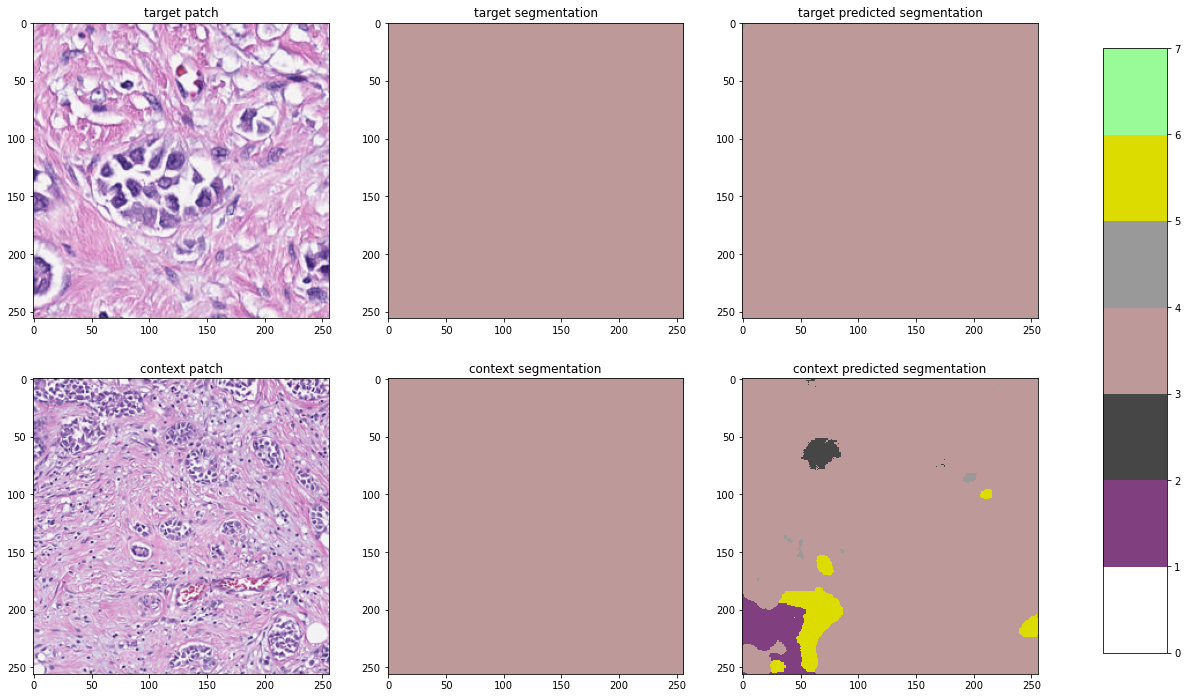

   class_id class_name  y_class_count  yp_class_count
0       6.0     Stroma          65536           65536


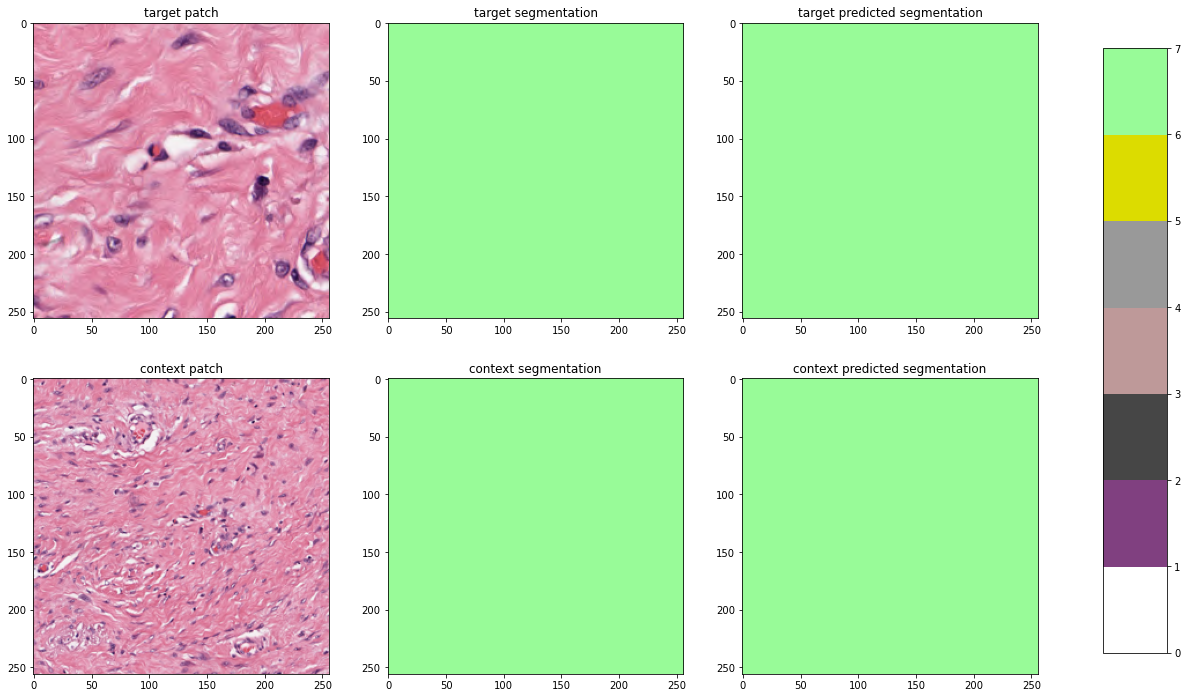

   class_id class_name  y_class_count  yp_class_count
0       5.0      Other        65536.0             NaN
1       2.0        CIS            NaN         15442.0
2       3.0        IDC            NaN         50094.0


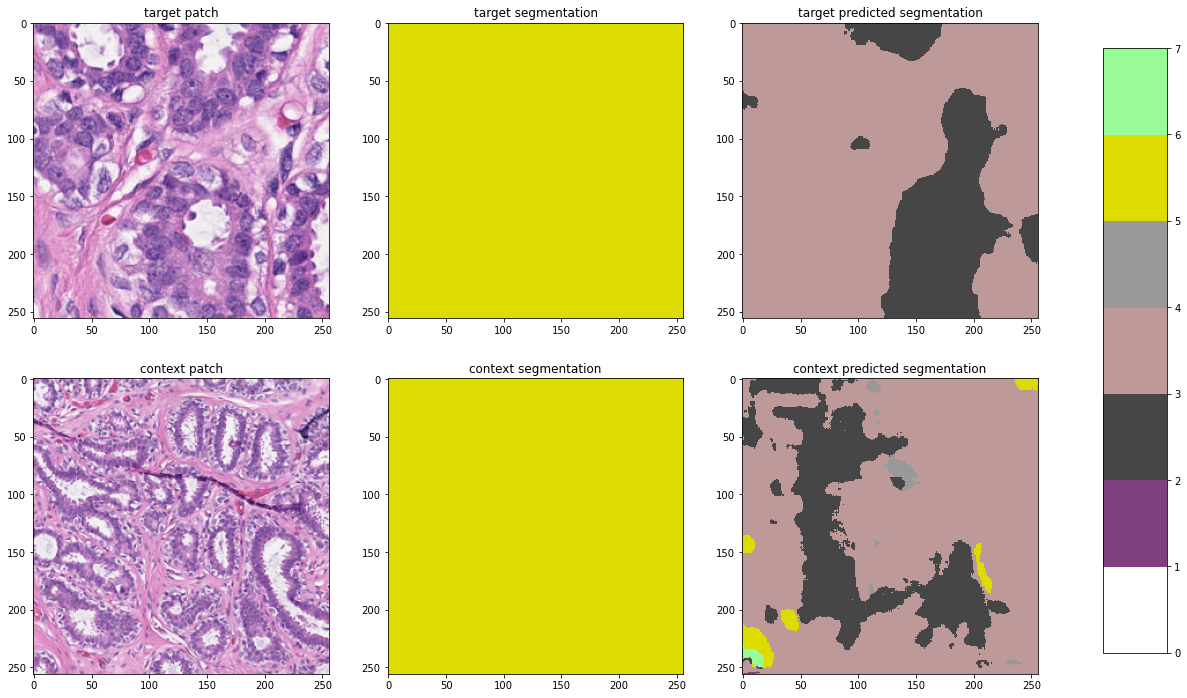

   class_id class_name  y_class_count  yp_class_count
0       3.0        IDC        65536.0            9781
1       2.0        CIS            NaN           55755


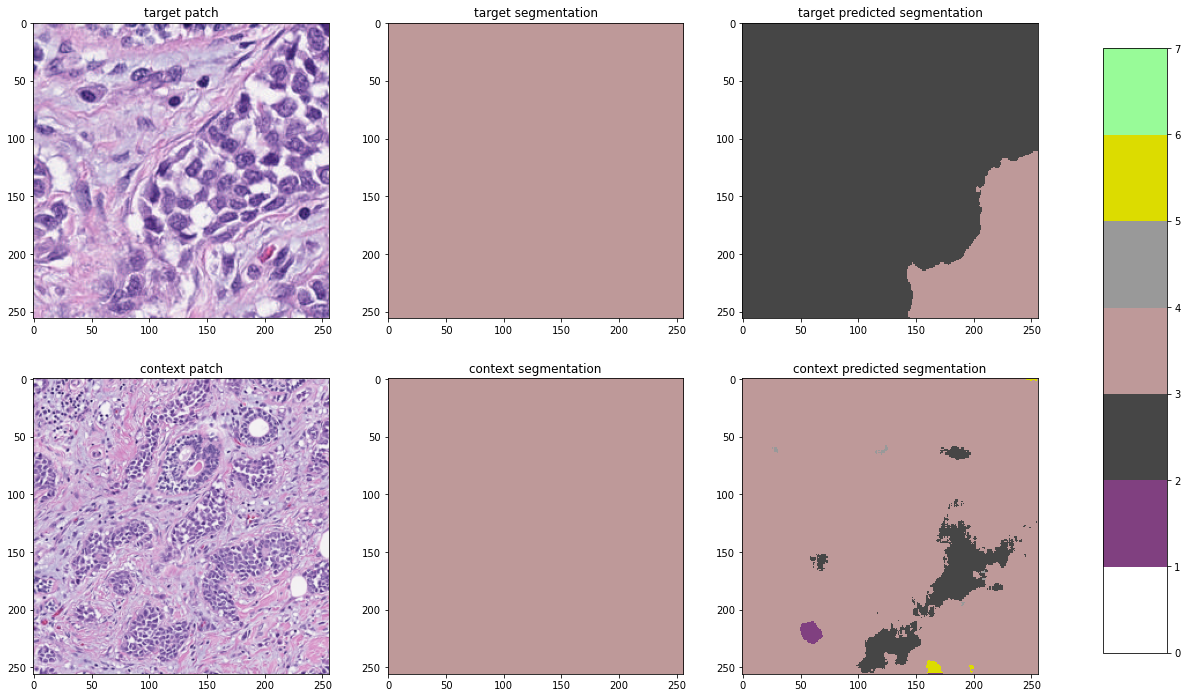

   class_id class_name  y_class_count  yp_class_count
0       5.0      Other        65536.0             NaN
1       2.0        CIS            NaN          6235.0
2       3.0        IDC            NaN         54060.0
3       4.0        ILC            NaN          5241.0


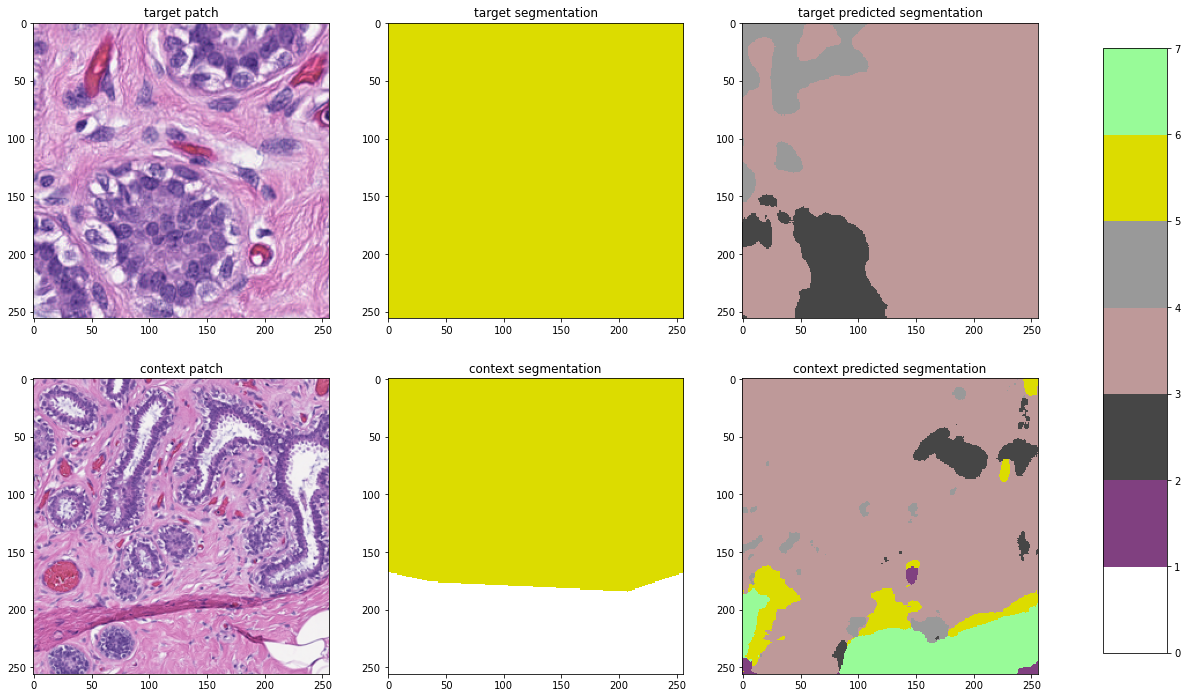

   class_id class_name  y_class_count  yp_class_count
0       6.0     Stroma          65536           65536


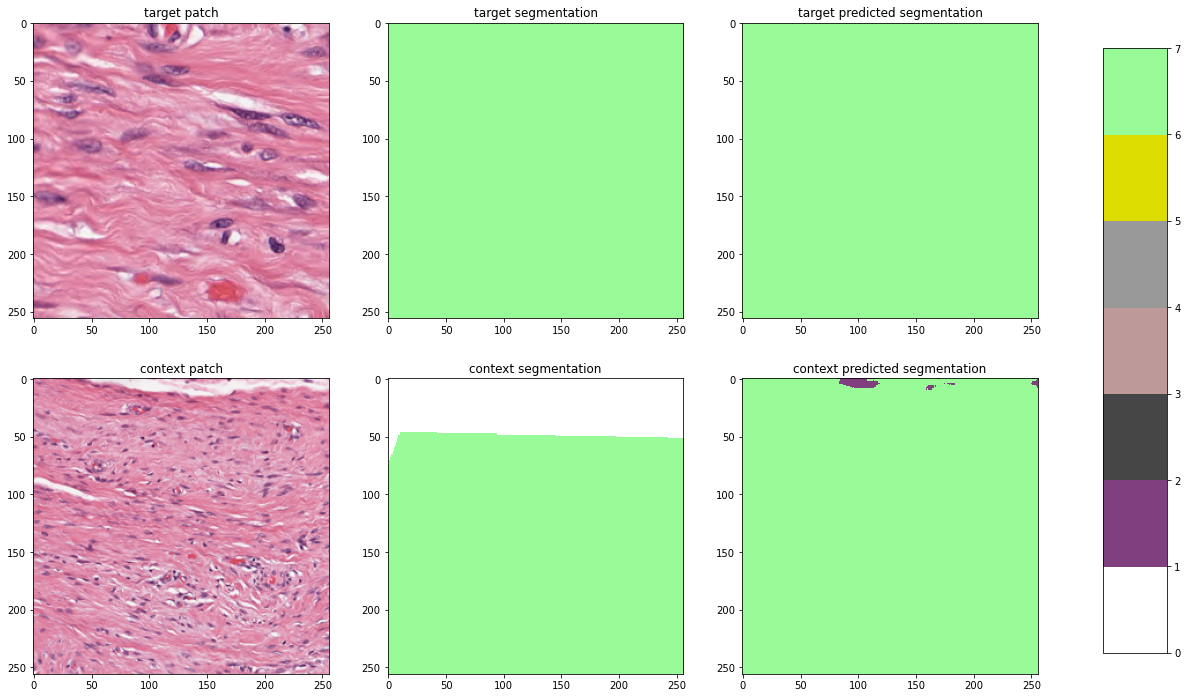

   class_id class_name  y_class_count  yp_class_count
0       6.0     Stroma          65536           65536


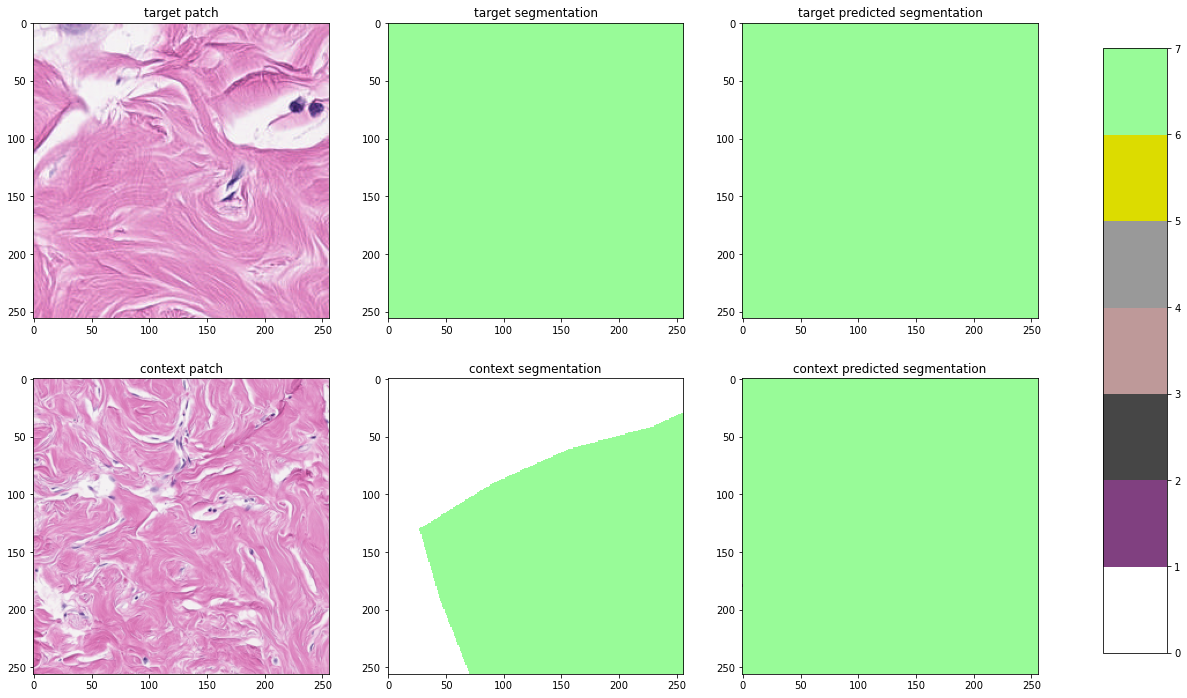

   class_id class_name  y_class_count  yp_class_count
0       6.0     Stroma          65536           65536


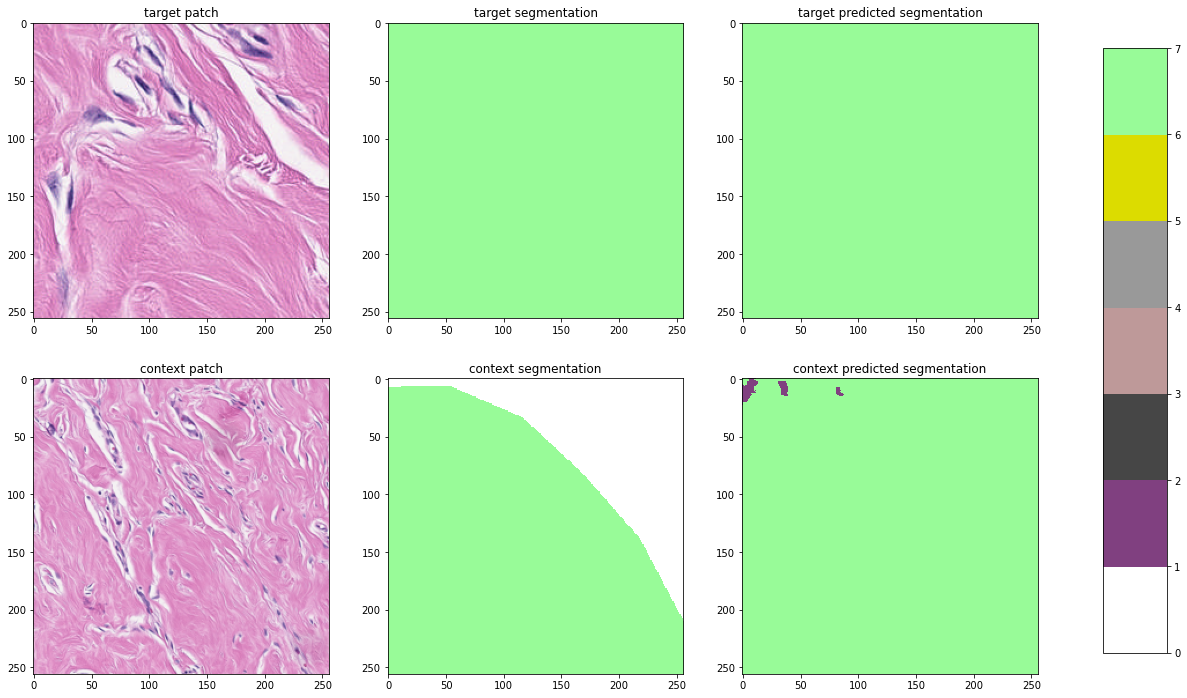

   class_id class_name  y_class_count  yp_class_count
0       5.0      Other        65536.0             NaN
1       2.0        CIS            NaN         26011.0
2       3.0        IDC            NaN         39525.0


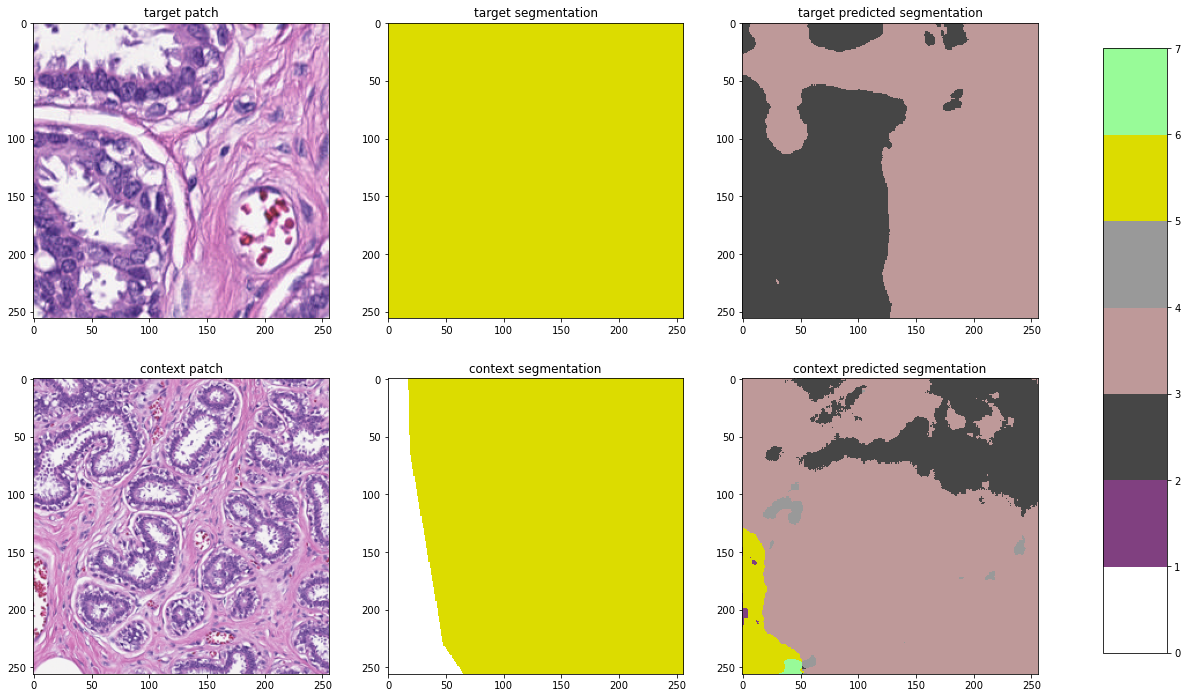

   class_id class_name  y_class_count  yp_class_count
0       3.0        IDC        65536.0           64055
1       2.0        CIS            NaN            1481


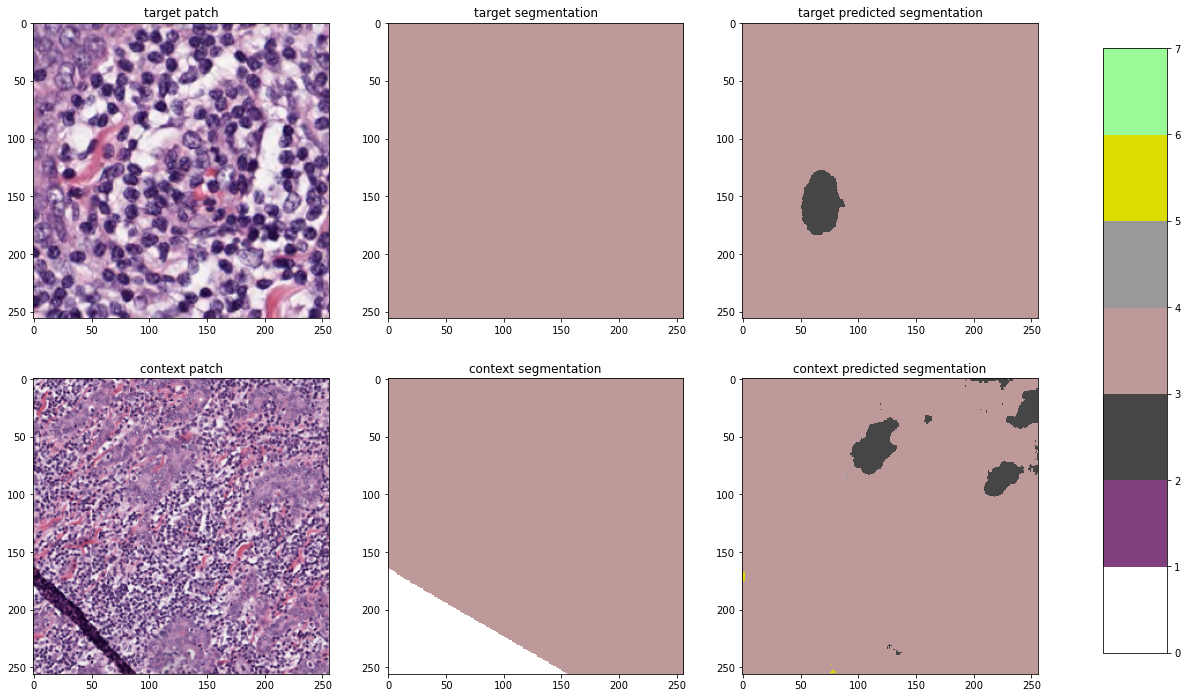

   class_id class_name  y_class_count  yp_class_count
0       3.0        IDC        65536.0           60136
1       4.0        ILC            NaN            5400


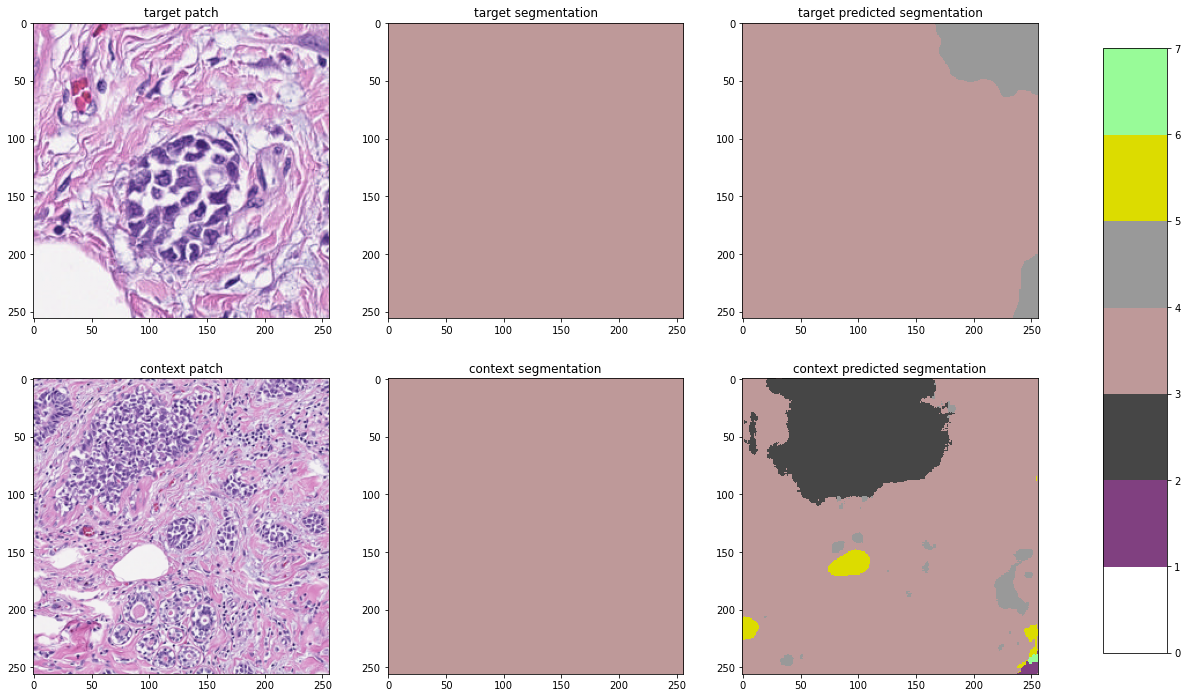

   class_id class_name  y_class_count  yp_class_count
0       3.0        IDC        65536.0             NaN
1       6.0     Stroma            NaN         65536.0


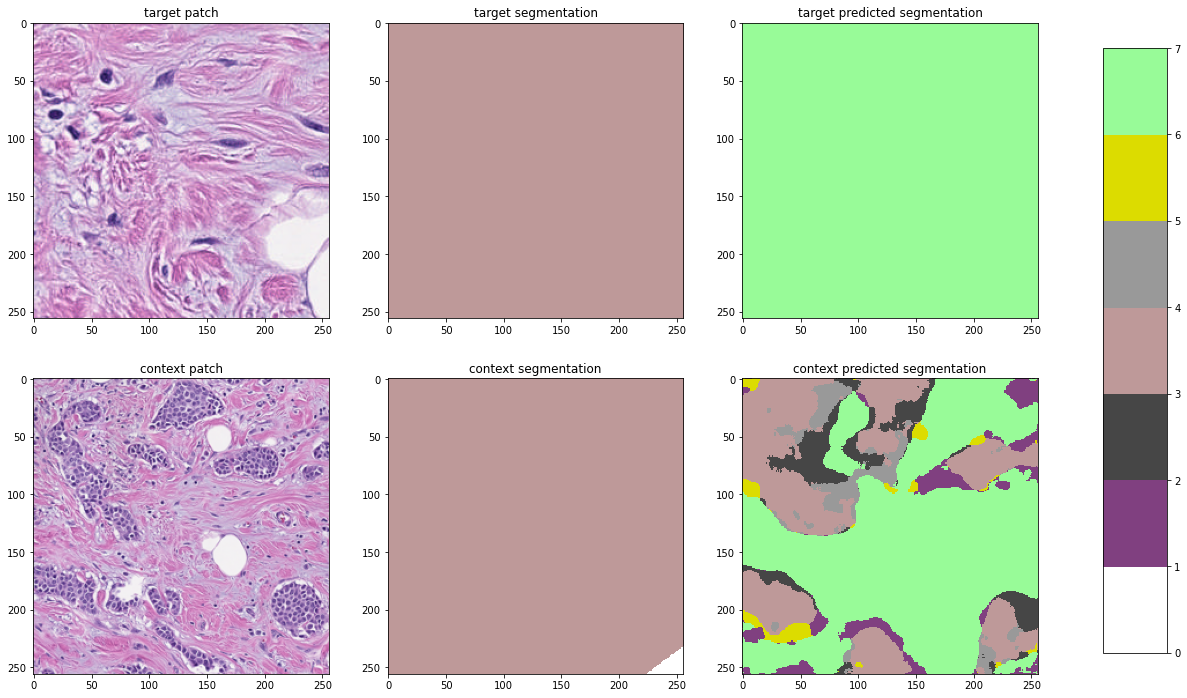

   class_id class_name  y_class_count  yp_class_count
0       6.0     Stroma          65536           65536


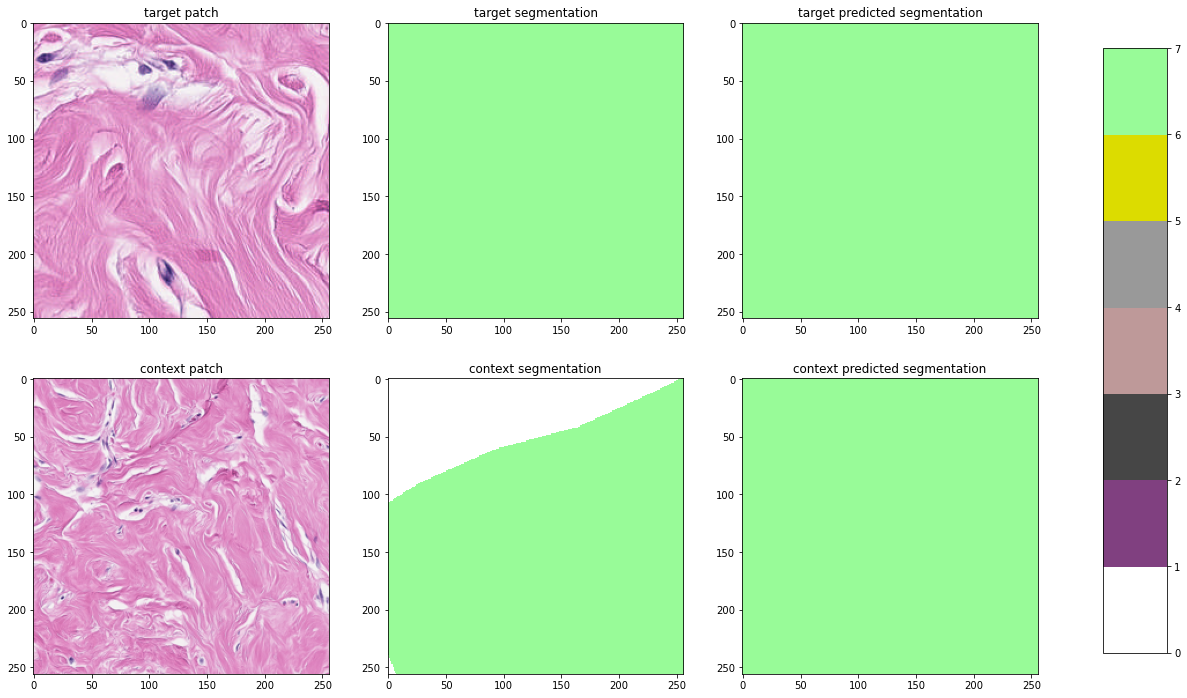

   class_id class_name  y_class_count  yp_class_count
0       5.0      Other        65536.0             NaN
1       2.0        CIS            NaN         26198.0
2       3.0        IDC            NaN         39338.0


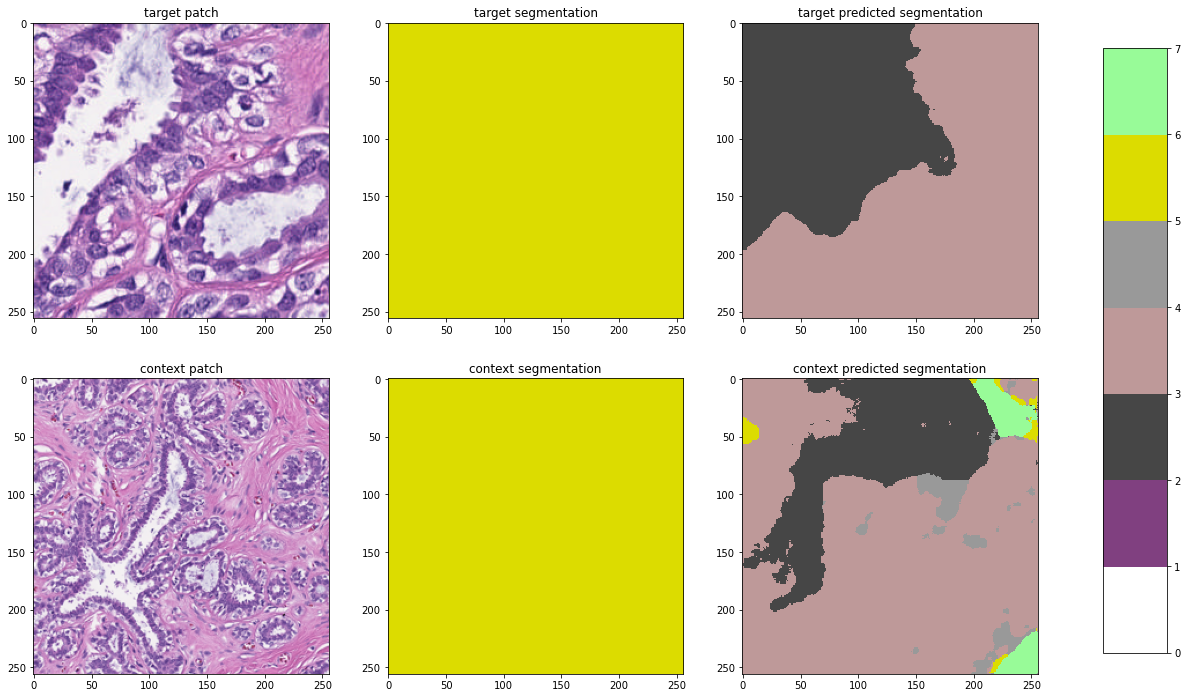

In [17]:
# use testGenerator
tsz = 256
max_iter = 1 # int(np.floor(len(classmeta_test) / params['batch_size']))  
i = 0
for (X_c, X_t), (Y_c, Y_t) in test_generator:
    i += 1

        
    YP_c, YP_t = hooknet.predict([X_c, X_t])
    YP_t = np.reshape(YP_t, (len(YP_t), tsz, tsz, -1))
    YP_t = np.argmax(YP_t, axis=-1)
    YP_c = np.reshape(YP_c, (len(YP_c), tsz, tsz, -1))
    YP_c = np.argmax(YP_c, axis=-1)
    
    for j in range(params['batch_size']):
        x_c = X_c[j]
        x_t = X_t[j]
        y_c = Y_c[j]
        y_t = Y_t[j]
        
        yp_c = YP_c[j]
        yp_t = YP_t[j]
        
        y_t_ids, y_t_counts = np.unique(y_t, return_counts=True)
#         print("original segmentation stats (target):", y_t_ids, y_t_counts)
    
        y_c_ids, y_c_counts = np.unique(y_c, return_counts=True)
#         print("original segmentation stats (context):", y_c_ids, y_c_counts)
        
        y_t_class_names = [new_class_names[int(idx)] for idx in y_t_ids]
        y_t_data = tuple(zip(list(y_t_ids), y_t_class_names, list(y_t_counts)))
        df_y_t = pd.DataFrame(y_t_data, columns=['class_id', 'class_name', 'y_class_count'])
        
        yp_t_ids, yp_t_counts = np.unique(yp_t, return_counts=True)
#         print("predicted segmentation stats (target):", yp_t_ids, yp_t_counts)
    
        yp_c_ids, yp_c_counts = np.unique(yp_c, return_counts=True)
#         print("predicted segmentation stats (context):", yp_c_ids, yp_c_counts)
        
        yp_t_class_names = [new_class_names[int(idx)] for idx in yp_t_ids]
        yp_t_data = tuple(zip(list(yp_t_ids), yp_t_class_names, list(yp_t_counts)))
        df_yp_t = pd.DataFrame(yp_t_data, columns=['class_id', 'class_name', 'yp_class_count'])
        
        df = df_y_t.merge(df_yp_t, on=['class_id', 'class_name'], how='outer')
        print(df)
        
        fig, ax = plt.subplots(2, 3, figsize=(18, 12))
        ax[0][0].imshow(x_t)
        ax[0][0].set_title("target patch")
        seg_image = ax[0][1].imshow(y_t, cmap, norm=norm, interpolation='nearest')
        ax[0][1].set_title("target segmentation")
        pred_image = ax[0][2].imshow(yp_t, cmap, norm=norm, interpolation='nearest')
        ax[0][2].set_title("target predicted segmentation")

        ax[1][0].imshow(x_c)
        ax[1][0].set_title("context patch")
        seg_image = ax[1][1].imshow(y_c, cmap, norm=norm, interpolation='nearest')
        ax[1][1].set_title("context segmentation")
        pred_image = ax[1][2].imshow(yp_c, cmap, norm=norm, interpolation='nearest')
        ax[1][2].set_title("context predicted segmentation")

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        fig.colorbar(pred_image, spacing='proportional', ticks=bounds, cax=cbar_ax)
        plt.show()
    
    if i == max_iter:
        break


In [ ]:
YP_t.shape

In [ ]:
tsz = 256

# for patch_name in classmeta_test['patch_name'].values[900:901]:
# for patch_name in classmeta_validation['patch_name'].values[6:7]:
# for patch_name in classmeta_train['patch_name'].values[100:101]:
    print("patch name: ", patch_name)
    with h5py.File(os.path.join(patches_folder, patch_name), 'r') as f:
        patch_t = f['patches_20x']['patch'][:]
        patch_c = f['patches_5x']['patch'][:]
        seg_t = f['patches_20x']['segmentation'][:]
        seg_c = f['patches_5x']['segmentation'][:]

        patch_t = patch_t.astype('float') / 255
        patch_c = patch_c.astype('float') / 255
                
        seg_ids_t, seg_counts_t = np.unique(seg_t, return_counts=True)
        print("original segmentation stats (target):", seg_ids_t, seg_counts_t)

        
        seg_class_names = [new_class_names[idx] for idx in seg_ids_t]
        seg_data = tuple(zip(list(seg_ids_t), seg_class_names, list(seg_counts_t)))
        df_seg = pd.DataFrame(seg_data, columns=['class_id', 'class_name', 'class_count'])
        
        
        patch_c = np.reshape(patch_c, (1, tsz, tsz, -1))
        patch_t = np.reshape(patch_t, (1, tsz, tsz, -1))

            
        pred_c, pred_t = hooknet.predict([patch_c, patch_t])
        
        pred_c = np.reshape(pred_c, (1, tsz, tsz, -1))
        pred_c = np.argmax(pred_c, axis=-1)
        pred_c = np.reshape(pred_c, (tsz, tsz))
        print("predicted segmentation stats (context):", np.unique(pred_c, return_counts=True))
        
        pred_t = np.reshape(pred_t, (1, tsz, tsz, -1))
        pred_t = np.argmax(pred_t, axis=-1)
        pred_t = np.reshape(pred_t, (tsz, tsz))
        print("predicted segmentation stats (target):", np.unique(pred_t, return_counts=True))
        
        pred_ids, pred_counts = np.unique(pred_t, return_counts=True)
        pred_class_names = [new_class_names[idx] for idx in pred_ids]
        pred_data = tuple(zip(list(pred_ids), pred_class_names, list(pred_counts)))
        df_pred = pd.DataFrame(pred_data, columns=['class_id', 'class_name', 'class_count_pred'])
        
        df = df_seg.merge(df_pred, on=['class_id', 'class_name'], how='outer')
        print(df)
    
    fig, ax = plt.subplots(2, 3, figsize=(18, 12))
    ax[0][0].imshow(np.reshape(patch_t, (tsz, tsz, -1)))
    ax[0][0].set_title("target patch")
    seg_image = ax[0][1].imshow(seg_t, cmap, norm=norm, interpolation='nearest')
    ax[0][1].set_title("target segmentation")
    pred_image = ax[0][2].imshow(pred_t, cmap, norm=norm, interpolation='nearest')
    ax[0][2].set_title("target predicted segmentation")
    
    ax[1][0].imshow(np.reshape(patch_c, (tsz, tsz, -1)))
    ax[1][0].set_title("context patch")
    seg_image = ax[1][1].imshow(seg_c, cmap, norm=norm, interpolation='nearest')
    ax[1][1].set_title("context segmentation")
    pred_image = ax[1][2].imshow(pred_c, cmap, norm=norm, interpolation='nearest')
    ax[1][2].set_title("context predicted segmentation")
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(pred_image, spacing='proportional', ticks=bounds, cax=cbar_ax)


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

N = 11 # Number of labels

# setup the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# define the data
x = np.random.rand(1000)
y = np.random.rand(1000)
# tag = np.random.randint(0, N, N) # Tag each point with a corresponding label
# print(tag)

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
print(cmap.N)

# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, N, N + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
print(bounds)
# print(norm)

# setup the plot
image = ax.imshow(pred, cmap='viridis', vmin=0, vmax=10, norm=norm, interpolation='nearest') # , cmap=cmap , norm=norm)

    
# scat = ax.scatter(x,y,c=tag,s=np.random.randint(100,500,N),cmap=cmap,     norm=norm)
# create the colorbar
cb = plt.colorbar(image, spacing='proportional', ticks=bounds)
cb.set_label('Custom cbar')
ax.set_title('Discrete color mappings')
plt.show()